# Semantic segmentation with Deep Learning
Centrale Nantes

Diana Mateus

### Introduction

In many areas of biomedical research, cell counts obtained from images are crucial data for diagnosing patients or for addressing hypotheses about developmental or pathological processes. Although the field changes reapidly, many cell counts are still done manually or with semi-automatic tools. An automatic tool can therefore save time, reduce variability, and improve results. In this notebook we will model the problem in terms of semantic segmentation and approach it by means of deep learning, and more specifically with the U-Net architecture.

### 1. Load modules and data

#### 1.1 Import modules

In [ ]:
#4S
# Import all the necessary libraries
import os
import datetime
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying

#Tensorflow, Keras and related modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.callbacks import History

#To save and reload models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import  plot_model


#Sklearn
import sklearn
from sklearn.model_selection import train_test_split

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.21.5
Skimage      : 0.19.2
Scikit-learn : 1.0.2
Tensorflow   : 2.9.1


#### 1.2 Import data
Download data from

- https://box.ec-nantes.fr/index.php/s/X84Bq5NYJ2zJRpR (small dataset to begin with)
- https://box.ec-nantes.fr/index.php/s/oXAx37DbpXPDF7T (larger dataset for final tests single zip -> good internet connection)

#### 1.3 Define the data path
Define the data path and change the directory to the defined topDir. Also specify the train and test directories

In [ ]:
#In case using colab
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#4S
topDir = "C:\\Users\\hatim\\Downloads\\apsta segmentation"
#topDir = "/content/drive/MyDrive/TP-image-segmentation/"
os.chdir(topDir)
print(os.listdir(os.path.join(topDir, 'miniinput')))  #see what's in the input folder (where data is in)
train_path = os.path.join(topDir, 'miniinput/stage1_train')  #path to training data file/folder
test_path = os.path.join(topDir, 'miniinput/stage1_test')   #path to test data file/folder

['stage1_test', 'stage1_train']


#### 1.4 Define global parameters
- Set seed for random values to a fix number (suggested: 42) to ensure that images are associated to the exactly corresponding masks .
- Define the desired image size as two global parameters:
``` img_height, img_width ```.
The defalut image size  is (64,64). You may want to reduce size for faster **debugging** or increase it (e.g. 256,256) for better results

In [ ]:
#4S
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# Set number of GPUs
#num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (64,64)  #Default to (256,266), use (None,None) if you do not want to resize imgs

#### 1.5 Read and preload the input image data
Read the data and create a tensor containing all the train and test data as well as their corresponding labels.

The following function ``get_images``  
- receives as input an image path (can be train or test), and a desired image shape for the output
- lists all files in the input image path.
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the images according to the ``img_height, img_width`` parameters.
- uses only the first three channels of the images.
- returns a numpy array (matrix) .
- uses ``%%time`` to display the time spent in loading.

Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8

In [ ]:
%%time
# Get training data
def get_images(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path) if id != ".DS_Store"]

    #X_data = np.array([skimage.io.imread(path)[:,:,:3] for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands

    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], output_shape=output_shape, mode='constant', preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands

    return X_data

X_train = get_images(train_path, output_shape=(img_height,img_width))

print(X_train.shape, X_train.dtype)



(50, 64, 64, 3) uint8
Wall time: 1.71 s


## This is an order 4 tensor with all the images layered in the first axis, it does not affect the model since there will just be an empty dimension in the tensors we deal with.

#### 1.6 Read and preload the expert annotation masks
The following function ``get_labels``  
- receives as input a mask path (can be train or test), and a desired image shape for the output.
- lists all files in the input path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the masks according to the ``img_height, img_width`` parameters.
- returns a numpy array (matrix) . Hint: define an ``np.array`` of type ``dtype=np.uint8`` to stock the data.
- uses ``%%time`` to display the time spent in loading.
- Runs the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3)) uint8
- This can take some minutes (reduce the number of images to accelerate the first tests and reduce memory demands if necessary)

In [ ]:
%%time
# Get training data labels
def get_labels(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path) if id != ".DS_Store"]

    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)

    # make sure to return the binary images but coded as floats to be compatible with the loss functions
    Y_data = np.array(Y_data, dtype=np.bool)

    return Y_data

Y_train = get_labels(train_path, output_shape=(img_height,img_width))
Y_train = Y_train.astype(np.float32)
print("We have {} labeled images of size ({},{}) and type {}".format(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],Y_train.dtype))




We have 50 labeled images of size (64,64) and type float32
Wall time: 14.3 s


<timed exec>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


#### 1.7 Visualize some examples of images and matching labels
Choose one index among the lists of images and labels and use ``plt.imshow`` to visualize side by side the corresponding image and mask.
You may want to use ```skimage.exposure.rescale_intensity``` for better visualization of the input.

Looking at image  44


Text(0.5, 1.0, 'mask')

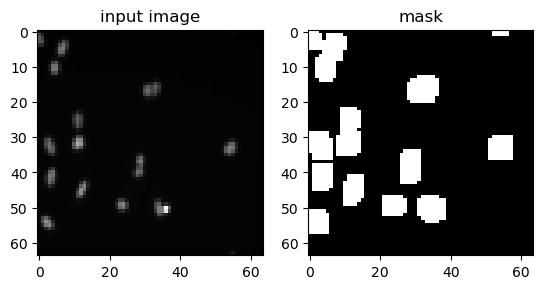

In [ ]:
%matplotlib inline

idx = np.random.randint(Y_train.shape[0], size=1)[0]


print ('Looking at image ', idx)

plt.subplot(1,2,1)
plt.imshow(skimage.exposure.rescale_intensity(X_train[idx, :, :, :]))
plt.title('input image')
plt.subplot(1,2,2)
plt.imshow(Y_train[idx, :, :],cmap='gray')
plt.title('mask')


## The mask depicts spots that are always larger than what the human eye considers as a separate element. This causes a lot of neighbour elements to form a large blob. So this is not ideal if we would want to count the number of elements. But the masks are representative of the input image.

### 2. Buidling the U-Net model
#### 2.1. Define the architecture

The u-net is composed of an input layer, an encoder and a decoder. Both the encoder and deconder consists of several blocks with similar structure but different dimensions. Each encoder blocks is composed of two convolutional layers of the same dimensions with a pooling and an activation function. With pooling operations, the 2D dimensions of the image are progressively reduced; to compensate the number of filters (or equivalently of feature channels) in each block is increased. The decoder reverses the operations of the encoder. Finally skip connections are created between the encoder and the decoder. To make these connections  it is useful to create a list pointing to the output of each encoder block as well as a list pointing to the output of each decoder block.

**a)** Building the model
- Create a function ```model``` that receives as input the image size
- Start by predefining as parameters within the function
    - the number of kernels/feature channels per block. Usually they have increasing powers of 2. For instance, ```n_channels=[16,32,64,128,256]```
    - a global kernel size ```(3,3)```
    - a weight initialization method (try `he_normal`)
- Create an input layer using the Keras function ``Input`` , the shape should match the the image dimensions.
- Declare the encoder blocks each composed of:
    - two convolutional layers. Use ``Conv2D``.
    - one maxpool layer (except for the last block). Use ``MaxPooling2D``
    - use relu activations
    - create a list pointing to each of the encoder blocks to be able to refer to them later while creating the skip connections
    - **Hint** Define one block of convolution+pool+relu then create a loop to iterate over the different blocks

- Define the decoder blocks each composed of:
    - one Transpose convolution layer.
    - two convolutional layers.
    - use relu activations
    - create a list with pointing to each encoder blocks to be able to refer to them later the skip connections
    - **Hint** Define one block of transposed convolution+conv+relu then create a loop to iterate over the different blocks


- The output layer should be a Transpose convolution layer with a 'sigmoid' activatin and a 'glorot_normal' initialization

- Use the lists created above to create the skip connections
    - connecting for each resolution the output of the encoder blocks to the input of the decoder blocks.

- Use the keras function ``Model`` to identify this function as the architecture and use the output of ```Model``` as the return value of the unet_model function


In [ ]:
def unet_model(img_width=64, img_height=64):

    #define the architecture parameters
    n_channels = [16,32,64,128,256]  #the number of kernels/feature channels per block
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer
    encoder_list = []
    decoder_list = []
    copies = {} #for copies and crops

    # Use Keras Input layer to create one
    inp0 = tf.keras.layers.Input(shape=(img_width,img_height,3))
    inp = inp0
    # Encoder
    for n in n_channels:
        enc = tf.keras.layers.Conv2D(filters =n,kernel_size = k_size, kernel_initializer=k_init,activation='tanh',padding="same")(inp)
        enc2 = tf.keras.layers.Conv2D(filters =n,kernel_size = k_size, kernel_initializer=k_init,activation='tanh',padding="same")(enc)
        if n!= 256:
            mp = tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding="same")(enc2)
            copies[n] = inp
            inp = mp
    encoder_list.append(enc2)

    # Decoder
    for n in n_channels[::-1]:
        if n != 16:
            dec0 = tf.keras.layers.Conv2DTranspose(strides=(2,2),filters=n,kernel_size = k_size, kernel_initializer=k_init,activation='relu',padding="same")(mp)
        elif n != 256: #copie sans besoin de crop
            dec0 = tf.keras.layers.Concatenate(axis=3)([copies[n], dec0])
        else: dec0 = mp
        dec1 = tf.keras.layers.Conv2D(filters =n,kernel_size = k_size, kernel_initializer=k_init,activation='tanh',padding="same")(dec0)
        dec2 = tf.keras.layers.Conv2D(filters =n,kernel_size = k_size, kernel_initializer=k_init,activation='tanh',padding="same")(dec1)
        mp = dec2

    decoder_list.append(mp)
    # Output

    outp = tf.keras.layers.Conv2DTranspose(strides=(1,1),filters =1,kernel_size = k_size, kernel_initializer='glorot_normal',activation='sigmoid',padding="same")(dec2)

    #Build Model with the architecture
    model = Model(inputs=[inp0], outputs=[outp])

    return model

#### 2.2. Define the losses

Define and explain how to use the Dice coefficient and the binarry crossentropy as loss and metrics for the segmentation. Create a costum dice loss that is a weighted average between the two

In [ ]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    inter = y_true*y_pred


    score = 2*tf.math.reduce_sum(inter)/(tf.math.reduce_sum(y_true)+tf.math.reduce_sum(y_pred))

    return score

def dice_loss(y_true, y_pred):
    inter = y_true*y_pred
    loss = 1 - (2*tf.math.reduce_sum(inter)/(tf.math.reduce_sum(y_true**2)+tf.math.reduce_sum(y_pred**2)))

    return loss

def crossentropy(y_true,y_pred):
    train = y_true
    pred = y_pred
    n = tf.size(train)
    n = tf.cast(n,'float32')
    cost = tf.math.reduce_sum(train*tf.math.log(pred+1e-6)+(1-train)*tf.math.log(1-pred+1e-6))
    return -1*cost/n




def costum_dice_loss(y_true, y_pred):
    #a,b = K.theano.shared(y_true),K.theano.shared(y_pred)
    print(y_true.dtype,y_pred.dtype)
    return 0.5*dice_loss(y_true, y_pred)+0.5*crossentropy(y_true,y_pred)

#### 2.3 Define the optimizer

In [ ]:
# Set optmizer, loss and metric
optimizer = 'adam'
loss      = costum_dice_loss
metrics   = ['acc']


#### 2.4 Compile the model

In [ ]:
#instantiate the model

model = unet_model(64,64)

#summary
model.summary()
#compile the model

model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_148 (Conv2D)            (None, 64, 64, 16)   448         ['input_11[0][0]']               
                                                                                                  
 conv2d_149 (Conv2D)            (None, 64, 64, 16)   2320        ['conv2d_148[0][0]']             
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 32, 32, 16)  0           ['conv2d_149[0][0]']             
 )                                                                                          

In [ ]:
#run the following cell to visualize the created model
l = []
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### 3. Trainning and testing

#### 3.1 Launch the training
- Use the ```model.fit``` function to launc the training,
- save the output of the model.fit which provides the history of the training results.
- Measure the overall time with ```%%time``` at the beginning of the notebook cell


In [ ]:
X_test = get_images(test_path, output_shape=(img_height,img_width))
Y_predict = model.predict(X_test)

1/1 [==============================] - 0s 316ms/step


In [ ]:
%%time
# Fit model
epochs= 120

batch_size= 30
history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,verbose=1)
np.save('my_history_TP_full.npy',history.history)


## The biggest changes occur in the first epochs, which is expected since it's the first times that each training element is seen.

In [ ]:
#history=np.load('my_history_TP.npy',allow_pickle='TRUE').item()

#### 3.2. Save the model
Save the final model ``model_out.save_weights`` with an hdf5 format.

In [ ]:
model.save_weights('model1_weights_tanh.hdf5')


## The weight file is 10mB, considering how we started with 16 filters up to 256, instead of 64 up to 1024 like in the actual U-NET mode. It is kind of light when I compare this with the TASED-Net model I use in my PRTSI project that has a 80mB size for generating visual saliency maps from videos.

#### 3.3. Plot the loss and the metrics

from the output of the fit function

Text(0.5, 0, 'epochs')

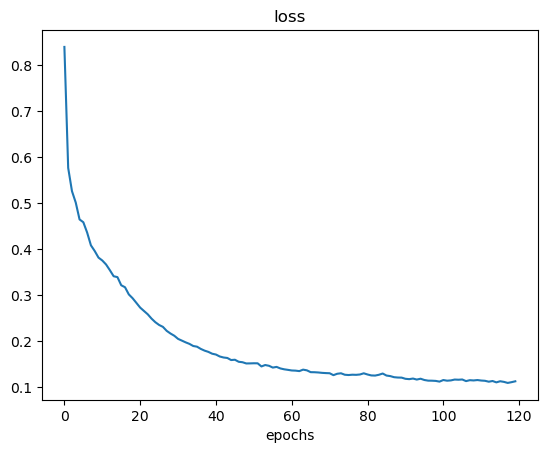

In [ ]:
plt.plot(history.history['loss'])
plt.title("loss")
plt.xlabel("epochs")

Text(0.5, 0, 'epochs')

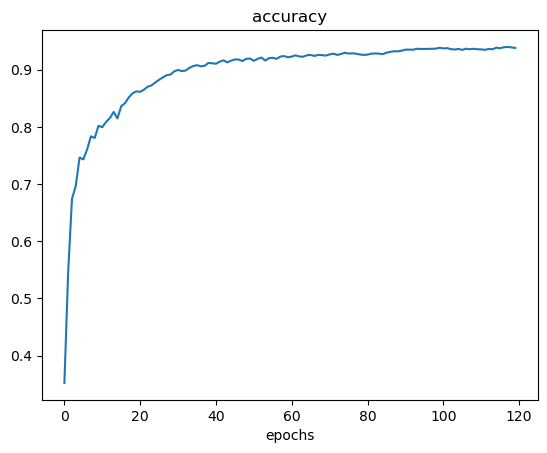

In [ ]:
plt.plot(history.history['acc'])
plt.title("accuracy")
plt.xlabel("epochs")

## We notice that the loss and accuracy functions are a lot more smoother with tanh activations than with ReLu. The duration for the training was approximately the same (around 1min10sec) for both activation functions.

#### 3.4. Test
Load the test images, make predictions and visualize the predictions



In [ ]:
# if required reload the model
# model.load_weights('model1_weights.hdf5')

Looking at image  6


Text(0.5, 1.0, 'mask')

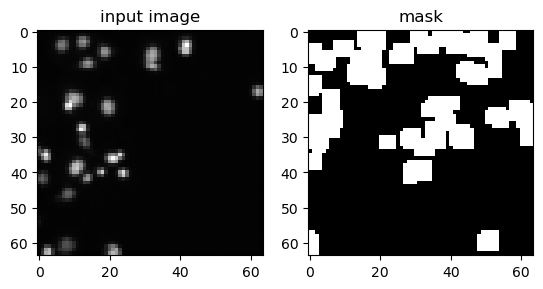

In [ ]:
%matplotlib inline

idx = np.random.randint(Y_predict.shape[0], size=1)[0]


print ('Looking at image ', idx)

plt.subplot(1,2,1)
plt.imshow(skimage.exposure.rescale_intensity(X_test[idx, :, :, :]))
plt.title('input image')
plt.subplot(1,2,2)
plt.imshow(Y_train[idx, :, :],cmap='gray')
plt.title('mask')


## The predictions are very far from what we would expect, despite training the model to a sufficient extent where the loss would stop decreasing. So by looking at the curves there is no underfitting and the accuracy got to 93%. Even if it not the only metric one should rely on the results are very far from being enough.

## For example in image 1 there is only one correct spot in the mask, all the other ones are completely miss the target. It is not a matter of symmetry because even if we would flip the mask it would make a bit more sense but not quite.

## As for image 9, there are lots of spots all over in the mask, so the accuracy is not that bad since in the input image there a lot of cells, but the specificity would be terrible here.

## In image 6 the specificity would also be bad, but the sensitivity would be decent here.

## In the end the masks are overall not doing the task we wanted them to. This does not get noticeably better when we use ReLu instead of tanh activations.

## If I had to guess what went wrong with the model, I would probably see if the initial number of filters taht is 16 is too low to capture enough informations form the input image. I strongly doubt it has something to do with the padding since in the actual UNET architecture it seems that they use "valid" padding (no padding). I did not investigate any further or test this hypothesis.

### 4 Comparison and Improvement

Try making changes to improve the results. Do at least one of the following modifications
- Change the architecture (use the one from the tf example, or add other types of layers (e.g. dropout) or non-linarities (e.g. leaky relu) and compare the training curves
- add data augmentation (rotation, flip, translation of each image)
- add an explicit validation set and ilustrate the intermediate results and metrics on the validation set
- add data generators (to sample and augment data online)





## We decided to go with the change of non linearity activation function, we replaced all the ReLu convolutions with hyperbolic tangent.